# Article Spinner

Library Import

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import scipy.sparse
import json
import flatdict
import random

from mergedeep import merge, Strategy
from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize, treebank
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from collections import defaultdict, Counter
from collections.abc import Mapping

# Data Loading

CSV Data Loading

In [32]:
bbc_file_path = "bbc-dataset/bbc/business/001.txt"

news_text = []

with open(bbc_file_path, "r", encoding = "utf-8") as f:
    news_text = f.read().splitlines()[1:]
    news_text = " ".join(news_text)
    # Remove all empty strings from list.
    news_text = sent_tokenize(news_text)

news_text[:8]

[' Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.',
 'The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales.',
 'TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.',
 'Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.',
 'Time Warner said on Friday that it now owns 8% of search-engine Google.',
 'But its own internet business, AOL, had has mixed fortunes.',
 'It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.',
 "However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues."]

## Data Visualization

Combine All Sentences into One

In [18]:
news_text_lowercase_one_sentence = " ".join(news_text)

print(news_text_lowercase_one_sentence[:500])

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8


Word Cloud

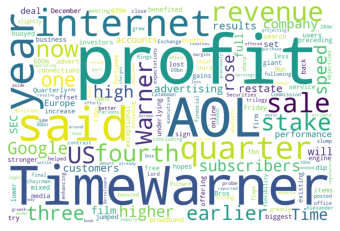

In [19]:
word_cloud_plotting = WordCloud(width = 1200, height = 800, background_color = "white", random_state = 100)
word_cloud_plotting.generate(news_text_lowercase_one_sentence)

plt.axis("off")
plt.imshow(word_cloud_plotting)

## Data Modelling

Convert Sentences into Words by using Word Tokenize

In [20]:
def convert_sentences_into_words(sentence, end_word = "<end>"):
    added_end_sentence = sentence
    added_end_sentence_tokenized = added_end_sentence.split(" ")
    if added_end_sentence_tokenized[-1] == ".":
        del added_end_sentence_tokenized[-1]
        
    added_end_sentence_tokenized.append(end_word)
    return added_end_sentence_tokenized

news_text_tokenized = list(map(convert_sentences_into_words, news_text))

print(news_text_tokenized[:10])

[['Quarterly', 'profits', 'at', 'US', 'media', 'giant', 'TimeWarner', 'jumped', '76%', 'to', '$1.13bn', '(£600m)', 'for', 'the', 'three', 'months', 'to', 'December,', 'from', '$639m', 'year-earlier.The', 'firm,', 'which', 'is', 'now', 'one', 'of', 'the', 'biggest', 'investors', 'in', 'Google,', 'benefited', 'from', 'sales', 'of', 'high-speed', 'internet', 'connections', 'and', 'higher', 'advert', 'sales.', '<end>'], ['TimeWarner', 'said', 'fourth', 'quarter', 'sales', 'rose', '2%', 'to', '$11.1bn', 'from', '$10.9bn.', '<end>'], ['Its', 'profits', 'were', 'buoyed', 'by', 'one-off', 'gains', 'which', 'offset', 'a', 'profit', 'dip', 'at', 'Warner', 'Bros,', 'and', 'less', 'users', 'for', 'AOL.Time', 'Warner', 'said', 'on', 'Friday', 'that', 'it', 'now', 'owns', '8%', 'of', 'search-engine', 'Google.', '<end>'], ['But', 'its', 'own', 'internet', 'business,', 'AOL,', 'had', 'has', 'mixed', 'fortunes.', '<end>'], ['It', 'lost', '464,000', 'subscribers', 'in', 'the', 'fourth', 'quarter', 'prof

In [21]:
class MiddleWordSparseMarkovModel():
    """
    Define a markov model that determines the probability of middle words, given next and previous words.

    Formula: 

                                count(Wt - 1 -> Wt -> Wt + 1)
    P (Wt | Wt - 1, Wt + 1) =  -------------------------------
                                count(Wt - 1 -> Any Word -> Wt + 1)
    
    """
    def __init__(self, number_of_orders_in_state_transition = 4):
        """
        number_of_orders_in_state_transition: Number of orders in state transition.
        
        numerator_dict: Dictionary for counting words in numerator. (count(Wt - 1 -> Wt -> Wt + 1))

        denominator_dict: Dictionary for counting words in denominator. (count(Wt - 1 -> Any Word -> Wt + 1))
        
        Determine how many previous and next words will be.

        Example:
        * 2: 1 word from previous and next words.
        * 3: 2 word from previous and next words.

        # 2 -> 3 words
        # 4 -> 5 words
        # 6 -> 7 words

        If the user gives an odd number, it will raises an exception.

        """
        if number_of_orders_in_state_transition % 2 != 0:
            raise NotImplementedError("Please use even number to determine the order! Example: 2, 4, 6, etc.")

        self.state_transition_dict = {}
        self.number_of_words = number_of_orders_in_state_transition + 1
        self.number_of_orders_in_state_transition = number_of_orders_in_state_transition
        self.numerator_dict = {}
        self.denominator_dict = {}

        print(f"Number of words: {self.number_of_words}")
        print(f"Number of orders in state transition: {self.number_of_orders_in_state_transition}")

    def _debug_dictionary(self):
        print(json.dumps(self.numerator_dict, indent = 4))
        print(json.dumps(self.denominator_dict, indent = 4))

    def debug_state_transition_dict(self):
        print(json.dumps(self.state_transition_dict, indent = 4))

    def _populate_state_transition_dictionary(self):
        """
        Calculate the probability of 1st word, to 2nd word, to 3th word, ... (nth word, given in number_of_orders_in_state_transition) 
        
        in given sentences.

        Formula: 
        
        * For 2nd order:
            Aijk = count(i -> j -> k) / count(i -> k)

            Where:

                -- i = First Word

                -- j = Second word
                
                -- k = third word

        * This does applies to nth order:
            Ai...no_order = count(i -> j -> ... -> n) / count(i -> j -> ... -> n - 1)
        
        The probabilities will be stored at state_transition_dict.
        """
        self.state_transition_dict = defaultdict(dict)
        for global_key, numerator_value in self.numerator_dict.items():

            # Separate middle word and the rest of the word from the key in the dictionary.
            splitted_key = " ".join(global_key.split(' ')[0:self.number_of_words - 1])
            predicted_key = global_key.split(' ')[-1]

            # Numerator value has been given in the iteration.
            # Here, we determine the denominator value, by getting the value from .
            
            denominator_value = self.denominator_dict[splitted_key]

            # Divide numerator_value by denominator_value to get the probability of given word.
            # Then, we insert the value to the state_transition_dict.
            self.state_transition_dict[splitted_key][predicted_key] = numerator_value / denominator_value

            # print(f"Denominator: {denominator_value}")
            # print(f"Numerator: {numerator_value}")

        # self.debug_state_transition_dict()

    def _make_numerator_denominator_dict(self, train_documents):
        """
        Before applying the formula, we need to perform counting for numerator and denominator

        In this case:
        numerator: stored in numerator_dict
        denominator: stored in denominator_dict
        """
        numerator_dict = defaultdict(int)
        denominator_dict = defaultdict(int)
        
        for document in train_documents:
            for index in range(len(document) - self.number_of_orders_in_state_transition):

                # Split the string based on our number of orders in state transition.
                # Example:
                # If we have 2nd order markov model: 
                # Ad sales boost Time Warner profit => ["Ad sales boost", "sales boost Time", "boost Time Warner", "Time Warner profit"]
                # Used for counting in numerator.
                
                numerator_string = " ".join(document[index : index + self.number_of_words])
                
                # Used for counting in denominator and numerator
                numerator_string_splitted = numerator_string.split(' ')
                denominator_string_splitted = numerator_string_splitted.copy()

                middle_word = numerator_string_splitted[self.number_of_words // 2]

                # Remove the element from index in list numerator_string_splitted
                del numerator_string_splitted[self.number_of_words // 2]
                del denominator_string_splitted[self.number_of_words // 2]

                # Place the prediction word at the end of the numerator splitted word
                numerator_string_splitted.append(middle_word)
                
                # Assign the key and increment!
                numerator_dict_key = " ".join(numerator_string_splitted)
                denominator_dict_key = " ".join(denominator_string_splitted)

                numerator_dict[numerator_dict_key] = numerator_dict.get(numerator_dict_key, 0) + 1
                denominator_dict[denominator_dict_key] = denominator_dict.get(denominator_dict_key, 0) + 1

        self.numerator_dict = numerator_dict
        self.denominator_dict = denominator_dict

    def fit(self, train_documents):
        self._make_numerator_denominator_dict(train_documents)
        # self._debug_dictionary()
        self._populate_state_transition_dictionary()

    def _remove_end_token(self, documents):
        documents_end_token_removed_token = []
        for document in documents:
            sentence_end_token_removed = document.copy()
            del sentence_end_token_removed[-1]
            documents_end_token_removed_token.append(sentence_end_token_removed)
        return documents_end_token_removed_token

    def predict_lines(self, documents, number_of_skips = 2):
        minimum_skip_allowed = self.number_of_orders_in_state_transition
        if number_of_skips < minimum_skip_allowed:
            raise ValueError(f"The number of skip per word must be more than {minimum_skip_allowed - 1}.")

        modified_documents = []

        for document in documents:
            modified_words_document = document.copy()
            for index in range(len(document) - self.number_of_orders_in_state_transition):
                # Process changing words if the number of iteration has reached the number of skip.
                if index % minimum_skip_allowed == 0:
                    indexes = list(range(index, index + self.number_of_words))
                    # print(indexes)
                    # Filter the words we'd like to process.
                    words = document[index : index + self.number_of_words]
                    # print(words)

                    # Get the middle word, and delete the middle word from the words we'd like to process.
                    middle_word_index = self.number_of_words // 2
                    del words[self.number_of_words // 2]

                    probability_words = " ".join(words)

                    # Determine the current probability.
                    possible_words = self.state_transition_dict[probability_words]
                    possible_word_keys = list(possible_words.keys())
                    possible_word_values = list(possible_words.values())
                    chosen_word_from_random = np.random.choice(a = possible_word_keys, p = possible_word_values)

                    # Apply word change to the modified words document variable.
                    modified_words_document[indexes[middle_word_index]] = chosen_word_from_random
            
            modified_documents.append(modified_words_document)

        return self._remove_end_token(modified_documents)
                
middle_word_markov_model = MiddleWordSparseMarkovModel(2)
middle_word_markov_model.fit(news_text_tokenized)
modified_news_text_tokenized = middle_word_markov_model.predict_lines(news_text_tokenized, number_of_skips = 2)
modified_news_text_tokenized

Number of words: 3
Number of orders in state transition: 2


[['Quarterly',
  'profits',
  'at',
  'US',
  'media',
  'giant',
  'TimeWarner',
  'jumped',
  '76%',
  'to',
  '$1.13bn',
  '(£600m)',
  'for',
  'the',
  'three',
  'months',
  'to',
  '$11.1bn',
  'from',
  '$639m',
  'year-earlier.The',
  'firm,',
  'which',
  'is',
  'now',
  'one',
  'of',
  'the',
  'biggest',
  'investors',
  'in',
  'Google,',
  'benefited',
  'from',
  'sales',
  'of',
  'high-speed',
  'internet',
  'connections',
  'and',
  'higher',
  'advert',
  'sales.'],
 ['TimeWarner',
  'said',
  'fourth',
  'quarter',
  'sales',
  'rose',
  '2%',
  'to',
  '$11.1bn',
  'from',
  '$10.9bn.'],
 ['Its',
  'profits',
  'were',
  'buoyed',
  'by',
  'one-off',
  'gains',
  'which',
  'offset',
  'a',
  'profit',
  'dip',
  'at',
  'Warner',
  'Bros,',
  'and',
  'less',
  'users',
  'for',
  'AOL.Time',
  'Warner',
  'said',
  'on',
  'Friday',
  'that',
  'it',
  'now',
  'owns',
  '8%',
  'of',
  'search-engine',
  'Google.'],
 ['But',
  'its',
  'own',
  'internet',
 

Pretty Print the modified document

In [22]:
def pretty_print_tokenized_document(documents):
    detokenizer = treebank.TreebankWordDetokenizer()
    detokenized_documents = []
    for document in documents:
        detokenized_document = detokenizer.detokenize(document)
        detokenized_documents.append(detokenized_document)
    return detokenized_documents

detokenized_documents = pretty_print_tokenized_document(modified_news_text_tokenized)
detokenized_documents

['Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to $11.1bn from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales.',
 'TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.',
 'Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google.',
 'But its own internet business, AOL, had has mixed fortunes.',
 'It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.',
 "However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.",
 "It intends to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing c